**Projeto Final - ICD - Versão 2 - IFB 2.2025**
_________________________________________________________________________
Alunos - Gustavo de Castro
Alunos - Felipe Augusto


Proposta de Projeto de Ciência de Dados  - Utilizar modelo de aprendizagem de máquina para avaliar a influência dos fatores demográficos e seu impacto no desfecho de SRAG no período de 2019-2025.

**Etapa 01 - Configuração Inicial e Definição de Variáveis Relevantes**
Nesta etapa é iniciada a configuração inicial; Os dados são reunidos a partir de pasta que contem o período 2019-2025.
Abaixo são listadas as variáveis selecionadas Demográficas; Geográficas e Desfecho.
- Data da Notificação;
- Gênero/Sexo;
- Idade;
- Raça;
- Escolaridade;
- Município/ID;
- Zona Geográfica (Urbana/Rural/Semi-Urbana);
- Desfecho;

_____________________________________________________________________
Nesta etapa organizadas e padronizadas tipos de dados e colunas; O objetivo é gerar um arquivo/base consolidado

In [ ]:
import pandas as pd
import glob
import os

# 1. Configurações Iniciais
diretorio_dados = "/Users/assis/Documents/ProjetoICD2025/BaseDadosSRAGParket" # Altere o caminho para a pasta onde está o banco de dados .parquet
padrao_arquivos = os.path.join(diretorio_dados, "*.parquet")
arquivos = sorted(glob.glob(padrao_arquivos))

# 2. Definição das Colunas Essenciais
# Selecionadas as demográficas, geográficas e o desfecho
cols_essenciais = [
    'DT_NOTIFIC',   # Temporal
    'CS_SEXO',      # Demográfico
    'NU_IDADE_N',   # Demográfico
    'CS_RACA',      # Demográfico (Socioeconômico)
    'CS_ESCOL_N',   # Demográfico (Socioeconômico)
    'SG_UF',        # Geográfico
    'ID_MUNICIP',   # Geográfico (opcional, para análise local)
    'CS_ZONA',      # Geográfico (Urbano/Rural)
    'CLASSI_FIN',   # Etiologia (Para filtrar COVID/Influenza)
    'EVOLUCAO'      # Target (Desfecho: Óbito ou Cura)
]

def carregar_e_padronizar(lista_arquivos, colunas):
    dfs = []
    
    for arquivo in lista_arquivos:
        print(f"Lendo: {os.path.basename(arquivo)}...")
        
        # O Parquet permite ler apenas as colunas desejadas (muito rápido)
        temp_df = pd.read_parquet(arquivo, columns=colunas)
        
        # PADRONIZAÇÃO DE TIPOS (Crítico para o SIVEP)
        # Convertemos colunas categóricas para String para evitar conflito Int/Float
        cols_para_str = ['CS_RACA', 'CS_ESCOL_N', 'CLASSI_FIN', 'EVOLUCAO', 'CS_ZONA']
        for col in cols_para_str:
            if col in temp_df.columns:
                temp_df[col] = temp_df[col].astype(str).str.replace('.0', '', regex=False)
        
        # Garante que idade seja numérica
        temp_df['NU_IDADE_N'] = pd.to_numeric(temp_df['NU_IDADE_N'], errors='coerce')
        
        dfs.append(temp_df)
    
    # Unificação
    print("Concatenando bases...")
    df_final = pd.concat(dfs, ignore_index=True)
    return df_final

# 3. Execução
df = carregar_e_padronizar(arquivos, cols_essenciais)

# 4. Verificação Básica e Salvamento
print("\n--- Resumo da Base Unificada ---")
print(f"Total de registros: {len(df)}")
print(f"Colunas carregadas: {df.columns.tolist()}")
print(f"Anos presentes: {pd.to_datetime(df['DT_NOTIFIC'], errors='coerce').dt.year.unique()}")

# Opcional: Salvar a base mestre unificada para não ter que rodar isso sempre
# df.to_parquet("sivep_2019_2025_master.parquet", index=False)

Lendo: INFLUD19-26-06-2025.parquet...
Lendo: INFLUD20-26-06-2025.parquet...
Lendo: INFLUD21-26-06-2025.parquet...
Lendo: INFLUD22-26-06-2025.parquet...
Lendo: INFLUD23-26-06-2025.parquet...
Lendo: INFLUD24-26-06-2025.parquet...
Lendo: INFLUD25-26-06-2025.parquet...
Concatenando bases...

--- Resumo da Base Unificada ---
Total de registros: 4371659
Colunas carregadas: ['DT_NOTIFIC', 'CS_SEXO', 'NU_IDADE_N', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'ID_MUNICIP', 'CS_ZONA', 'CLASSI_FIN', 'EVOLUCAO']
Anos presentes: [2019 2018 2020 2021 2022 2023 2024 2025]


**Etapa 2 - Ajustes de Dados**
Nesta etapa são feito ajustes de otimização, concatenação e exportação para a leitura da base de dados elaborada.

In [ ]:
import pandas as pd
import glob
import os

# --- CONFIGURAÇÃO ---
diretorio_dados = "/Users/assis/Documents/ProjetoICD2025/BaseDadosSRAGParket" #Altere o ca
arquivos = sorted(glob.glob(os.path.join(diretorio_dados, "*.parquet")))
arquivo_saida = "base_srag_demografica_2019_2025.parquet"

cols_essenciais = [
    'DT_NOTIFIC', 'CS_SEXO', 'NU_IDADE_N', 'CS_RACA', 
    'CS_ESCOL_N', 'SG_UF', 'CS_ZONA', 'CLASSI_FIN', 'EVOLUCAO'
]

# --- PROCESSAMENTO ---
dfs = []
for arquivo in arquivos:
    print(f"Processando: {os.path.basename(arquivo)}")
    temp_df = pd.read_parquet(arquivo, columns=cols_essenciais)
    
    # Padronização rápida para evitar erros de concatenação
    for col in ['CS_RACA', 'CS_ESCOL_N', 'CLASSI_FIN', 'EVOLUCAO', 'CS_ZONA']:
        temp_df[col] = temp_df[col].astype(str).str.replace('.0', '', regex=False).replace('nan', '9')
    
    temp_df['NU_IDADE_N'] = pd.to_numeric(temp_df['NU_IDADE_N'], errors='coerce')
    dfs.append(temp_df)

# Unificar
df_final = pd.concat(dfs, ignore_index=True)

# --- OTIMIZAÇÃO DE MEMÓRIA (Categorical Encoding) ---
# Transformar colunas repetitivas em 'category' reduz o tamanho do arquivo em até 80%
colunas_categoricas = ['CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'CS_ZONA', 'CLASSI_FIN', 'EVOLUCAO']
for col in colunas_categoricas:
    df_final[col] = df_final[col].astype('category')

# --- EXPORTAÇÃO ---
try:
    # Usamos o mecanismo 'pyarrow' para garantir compatibilidade total com Parquet
    df_final.to_parquet(
        arquivo_saida, 
        engine='pyarrow', 
        compression='snappy', # Equilíbrio ideal entre velocidade e tamanho
        index=False
    )
    print(f"\n✅ Sucesso! Arquivo gerado: {arquivo_saida}")
    print(f"Total de linhas processadas: {len(df_final)}")
    print(f"Tamanho aproximado na memória: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

except Exception as e:
    print(f"❌ Erro ao salvar o arquivo: {e}")

Processando: INFLUD19-26-06-2025.parquet
Processando: INFLUD20-26-06-2025.parquet
Processando: INFLUD21-26-06-2025.parquet
Processando: INFLUD22-26-06-2025.parquet
Processando: INFLUD23-26-06-2025.parquet
Processando: INFLUD24-26-06-2025.parquet
Processando: INFLUD25-26-06-2025.parquet

✅ Sucesso! Arquivo gerado: base_srag_demografica_2019_2025.parquet
Total de linhas processadas: 4371659
Tamanho aproximado na memória: 308.52 MB


**Etapa 3 - Limpeza, Padronização e Tratamento**

Nesta etapa é realizada a Limpeza temporal, Padronização de desfecho, Tratamento de dados de idade, dentre outros ajustes pertinentes a qualidade de dados.


In [5]:
import pandas as pd
import numpy as np

# 1. Carregar a base unificada
df = pd.read_parquet("base_srag_demografica_2019_2025.parquet")

# --- A. LIMPEZA TEMPORAL ---
# Converter datas e extrair Ano/Mês para análises futuras
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')
df = df.dropna(subset=['DT_NOTIFIC']) # Remove registros sem data
df['ANO'] = df['DT_NOTIFIC'].dt.year

# --- B. PADRONIZAÇÃO DO DESFECHO (TARGET) ---
# Manter apenas 1 (Cura) e 2 (Óbito). O resto (Ignorado/Outros) é descartado para o modelo.
df = df[df['EVOLUCAO'].isin(['1', '2'])].copy()
df['DESFECHO'] = df['EVOLUCAO'].map({'1': 'Cura', '2': 'Obito'})

# --- C. TRATAMENTO DE IDADE (O ponto mais sensível) ---
# No SIVEP, idades < 1 ano podem estar registradas de forma confusa.
# Vamos garantir que NU_IDADE_N seja apenas anos inteiros e remover absurdos.
df = df[(df['NU_IDADE_N'] >= 0) & (df['NU_IDADE_N'] <= 115)]

# Criar Faixas Etárias para análise demográfica
bins = [0, 2, 12, 19, 39, 59, 79, 120]
labels = ['Bebe', 'Crianca', 'Adolescente', 'Adulto_Jovem', 'Adulto', 'Idoso', 'Idoso_80+']
df['FAIXA_ETARIA'] = pd.cut(df['NU_IDADE_N'], bins=bins, labels=labels, right=False)

# --- D. TRATAMENTO DE CATEGORIAS (Labels Reais) ---
# Substituir códigos por nomes para que sua análise seja legível

map_raca = {'1': 'Branca', '2': 'Preta', '3': 'Amarela', '4': 'Parda', '5': 'Indigena', '9': 'Nao_Informado'}
df['CS_RACA_DESC'] = df['CS_RACA'].map(map_raca).fillna('Nao_Informado')

map_escol = {
    '0': 'Sem_Escolaridade', '1': 'Fundamental_1', '2': 'Fundamental_2', 
    '3': 'Medio', '4': 'Superior', '9': 'Nao_Informado'
}
df['CS_ESCOL_DESC'] = df['CS_ESCOL_N'].map(map_escol).fillna('Nao_Informado')

map_zona = {'1': 'Urbana', '2': 'Rural', '3': 'Periurbana', '9': 'Nao_Informado'}
df['CS_ZONA_DESC'] = df['CS_ZONA'].map(map_zona).fillna('Nao_Informado')

# --- E. REMOÇÃO DE COLUNAS ORIGINAIS (Opcional) ---
# Ficamos apenas com as colunas limpas para economizar memória
cols_finais = [
    'DT_NOTIFIC', 'ANO', 'CS_SEXO', 'NU_IDADE_N', 'FAIXA_ETARIA', 
    'CS_RACA_DESC', 'CS_ESCOL_DESC', 'SG_UF', 'CS_ZONA_DESC', 'DESFECHO'
]
df_limpo = df[cols_finais].copy()

print(f"Limpeza concluída! Registros restantes: {len(df_limpo)}")

Limpeza concluída! Registros restantes: 3867613


**Etapa 4 - Estatística de variáveis selecionadas**

Nesta etapa são detalhados algumas informações estatísticas de variáveis selecionadas - idade, sexo, raça, desfecho - para fins de visualização.

In [7]:
# Descritiva da Idade (Numérica)
descritiva_idade = df['NU_IDADE_N'].describe(percentiles=[.25, .5, .75, .95])
print("Estatísticas da Idade:\n", descritiva_idade)

# Descritiva das Categóricas (Frequência Relativa)
for col in ['CS_SEXO', 'CS_RACA', 'DESFECHO']:
    print(f"\nDistribuição de {col}:")
    print(df[col].value_counts(normalize=True) * 100)

Estatísticas da Idade:
 count    3.867659e+06
mean     4.919204e+01
std      2.785496e+01
min     -9.000000e+00
25%      3.000000e+01
50%      5.500000e+01
75%      7.100000e+01
95%      8.700000e+01
max      1.500000e+02
Name: NU_IDADE_N, dtype: float64

Distribuição de CS_SEXO:
CS_SEXO
M    53.344025
F    46.640229
I     0.015746
Name: proportion, dtype: float64

Distribuição de CS_RACA:
CS_RACA
1    42.303859
4    35.698623
9    16.584735
2     4.230207
3     0.898631
5     0.283944
Name: proportion, dtype: float64

Distribuição de DESFECHO:
DESFECHO
Cura     76.217707
Obito    23.782293
Name: proportion, dtype: float64


**Etapa 5 - Ajustes em colunas**

Nesta etapa são realizados alguns ajustes de consistência de dados de colunas.

In [ ]:
# 1. Garanta que a data é datetime
df['DT_NOTIFIC'] = pd.to_datetime(df['DT_NOTIFIC'], errors='coerce')

# 2. Crie a coluna ANO explicitamente (e remova possíveis NaTs)
df['ANO'] = df['DT_NOTIFIC'].dt.year

# 3. Importante: Verifique se existem linhas com ANO nulo e remova-as
df = df.dropna(subset=['ANO'])

# 4. Verifique se a coluna realmente existe agora
print(df.columns)   

Index(['DT_NOTIFIC', 'CS_SEXO', 'NU_IDADE_N', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF',
       'CS_ZONA', 'CLASSI_FIN', 'EVOLUCAO', 'DESFECHO', 'ANO'],
      dtype='object')


**Etapa 6 - Análises Gráficas**

Elaboração de Gráficos - Histograma; Boxplot; Gráfico de Barras

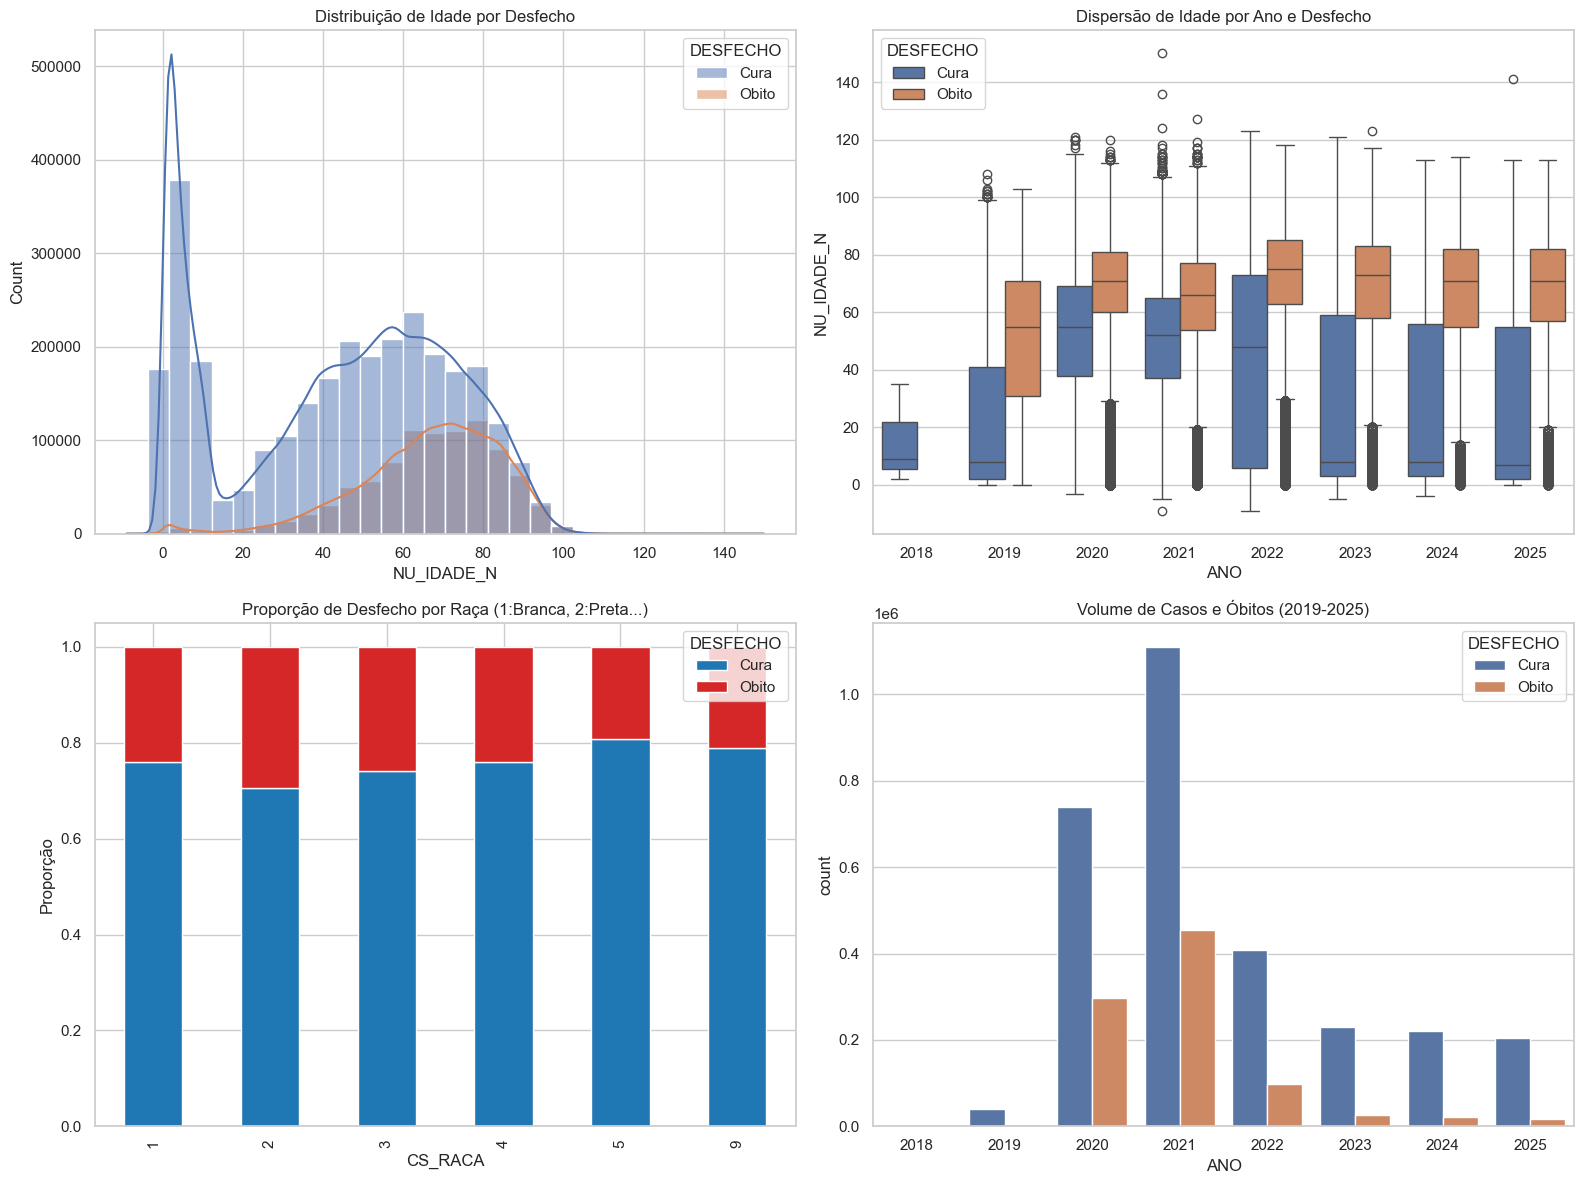

In [10]:
# Configuração visual
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histograma: Distribuição de Idade por Desfecho
sns.histplot(data=df, x='NU_IDADE_N', hue='DESFECHO', kde=True, ax=axes[0,0], bins=30)
axes[0,0].set_title('Distribuição de Idade por Desfecho')

# 2. Boxplot: Detecção de Dispersão e Outliers de Idade por Ano
sns.boxplot(data=df, x='ANO', y='NU_IDADE_N', hue='DESFECHO', ax=axes[0,1])
axes[0,1].set_title('Dispersão de Idade por Ano e Desfecho')

# 3. Gráfico de Barras: Impacto da Raça no Desfecho (Proporcional)
raca_desfecho = pd.crosstab(df['CS_RACA'], df['DESFECHO'], normalize='index')
raca_desfecho.plot(kind='bar', stacked=True, ax=axes[1,0], color=['#1f77b4', '#d62728'])
axes[1,0].set_title('Proporção de Desfecho por Raça (1:Branca, 2:Preta...)')
axes[1,0].set_ylabel('Proporção')

# 4. Gráfico de Comparação: Evolução de Casos por Ano
sns.countplot(data=df, x='ANO', hue='DESFECHO', ax=axes[1,1])
axes[1,1].set_title('Volume de Casos e Óbitos (2019-2025)')

plt.tight_layout()
plt.show()

**Etapa 7 - Analises Exploratórias**

Apresentação de dados relacionados a dispersão de idade; Média; Desvio-Padrão; Variância, Amplitude.

In [11]:
import pandas as pd

# 1. Garantir que os dados estão limpos para o cálculo
# Filtramos apenas os desfechos válidos e idades preenchidas
df_disp = df.dropna(subset=['NU_IDADE_N', 'ANO', 'DESFECHO'])

# 2. Cálculo das métricas de dispersão agrupadas
# Vamos calcular: Média (para contexto), Desvio Padrão, Variância e a Amplitude (Max - Min)
dispersao = df_disp.groupby(['ANO', 'DESFECHO'])['NU_IDADE_N'].agg(
    media='mean',
    desvio_padrao='std',
    variancia='var',
    minimo='min',
    maximo='max'
).reset_index()

# 3. Adicionar o Coeficiente de Variação (CV)
# O CV permite comparar a dispersão entre grupos com médias muito diferentes (ex: jovens vs idosos)
# CV = (Desvio Padrão / Média) * 100
dispersao['cv_percentual'] = (dispersao['desvio_padrao'] / dispersao['media']) * 100

# 4. Cálculo da Amplitude Interquartílica (IQR) - Fundamental para validar o Boxplot
def calcular_iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

iqr_result = df_disp.groupby(['ANO', 'DESFECHO'])['NU_IDADE_N'].apply(calcular_iqr).reset_index(name='iqr')

# Unir tudo numa tabela final
estatisticas_completas = pd.merge(dispersao, iqr_result, on=['ANO', 'DESFECHO'])

print("--- Estatísticas de Dispersão da Idade (2019-2025) ---")
print(estatisticas_completas.round(2))

--- Estatísticas de Dispersão da Idade (2019-2025) ---
     ANO DESFECHO  media  desvio_padrao  variancia  minimo  maximo  \
0   2018     Cura  15.33          17.39     302.33       2      35   
1   2019     Cura  23.06          26.72     713.83       0     108   
2   2019    Obito  50.10          26.90     723.42       0     103   
3   2020     Cura  52.02          22.82     520.52      -3     121   
4   2020    Obito  68.70          16.57     274.55       0     120   
5   2021     Cura  49.35          22.52     507.09      -9     150   
6   2021    Obito  64.73          16.51     272.68       0     127   
7   2022     Cura  42.78          32.79    1075.01      -9     123   
8   2022    Obito  71.26          19.05     362.83       0     118   
9   2023     Cura  27.50          31.57     996.46      -5     121   
10  2023    Obito  66.99          23.26     540.95       0     123   
11  2024     Cura  26.26          30.99     960.38      -4     113   
12  2024    Obito  64.73          2

In [ ]:
!pip install scikit-learn

**Etapa 8- Definição de Features**

Definição de Features para a escolha de modelos de análise de dados;
Features selecionadas
- nu_idade_n : Idade
- cs_sexo : sexo
- cs_raca : raça
- cs_escola_n : escolaridade
- cs_zona : zona geográfica - urbana/rural/periurbana/ignorado
- ano : ano de ocorrência
- desfecho : cura/óbito

In [ ]:
# 1. Definindo a lista de features (o que causou o erro)
features_finais = ['NU_IDADE_N', 'CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA', 'ANO']

# 2. Selecionando os dados e definindo o Alvo (y)
# Lembre-se: 'df_limpo' deve ser o nome do seu dataframe atualizado
X = df_limpo[features_finais].copy()
y = df_limpo['DESFECHO'].map({'Cura': 0, 'Obito': 1})

# 3. Tratamento de Categorias (One-Hot Encoding)
# Isso transforma as colunas de texto em números para o modelo
X = pd.get_dummies(X, columns=['CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA'], drop_first=True)

print("Features definidas e processadas com sucesso!")

**Etapa 9 - Ajuste em dataframe**

Verificação e ajuste de colunas/dataframe.
Detalhamento de novas colunas para melhor ajuste de dados e detalhamento em modelos.
Colunas detalhadas:
'NU_IDADE_N', 'ANO', 'CS_SEXO_I', 'CS_SEXO_M', 'CS_RACA_DESC_Branca', 'CS_RACA_DESC_Indigena', 'CS_RACA_DESC_Nao_Informado', 'CS_RACA_DESC_Parda', 'CS_RACA_DESC_Preta', 'CS_ESCOL_DESC_Fundamental_2', 'CS_ESCOL_DESC_Medio', 'CS_ESCOL_DESC_Nao_Informado', 'CS_ESCOL_DESC_Sem_Escolaridade', 'CS_ESCOL_DESC_Superior', 'CS_ZONA_DESC_Periurbana', 'CS_ZONA_DESC_Rural', 'CS_ZONA_DESC_Urbana'

In [21]:
# 1. Veja quais colunas você tem no momento
print("Colunas disponíveis no seu DataFrame:", df_limpo.columns.tolist())

# 2. Ajuste a lista abaixo conforme os nomes que apareceram no print acima
# Se no print apareceu 'CS_RACA_DESC', mude aqui embaixo.
features_finais = ['NU_IDADE_N', 'CS_SEXO', 'CS_RACA_DESC', 'CS_ESCOL_DESC', 'CS_ZONA_DESC', 'ANO']

# 3. Criar X e y com segurança
# Usamos apenas as colunas que REALMENTE existem para evitar o KeyError
colunas_presentes = [c for c in features_finais if c in df_limpo.columns]
X = df_limpo[colunas_presentes].copy()
y = df_limpo['DESFECHO'].map({'Cura': 0, 'Obito': 1})

# 4. Tratamento de Categorias (Encoding)
# Identifica automaticamente quais colunas são texto para fazer o dummies
cols_categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cols_categoricas, drop_first=True)

print("\nSucesso! Colunas processadas:", X.columns.tolist())

Colunas disponíveis no seu DataFrame: ['DT_NOTIFIC', 'ANO', 'CS_SEXO', 'NU_IDADE_N', 'FAIXA_ETARIA', 'CS_RACA_DESC', 'CS_ESCOL_DESC', 'SG_UF', 'CS_ZONA_DESC', 'DESFECHO']

Sucesso! Colunas processadas: ['NU_IDADE_N', 'ANO', 'CS_SEXO_I', 'CS_SEXO_M', 'CS_RACA_DESC_Branca', 'CS_RACA_DESC_Indigena', 'CS_RACA_DESC_Nao_Informado', 'CS_RACA_DESC_Parda', 'CS_RACA_DESC_Preta', 'CS_ESCOL_DESC_Fundamental_2', 'CS_ESCOL_DESC_Medio', 'CS_ESCOL_DESC_Nao_Informado', 'CS_ESCOL_DESC_Sem_Escolaridade', 'CS_ESCOL_DESC_Superior', 'CS_ZONA_DESC_Periurbana', 'CS_ZONA_DESC_Rural', 'CS_ZONA_DESC_Urbana']


In [ ]:
# 1. Definindo a lista de features (o que causou o erro)
features_finais = ['NU_IDADE_N', 'CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA', 'ANO']

# 2. Selecionando os dados e definindo o Alvo (y)
# Lembre-se: 'df_limpo' deve ser o nome do seu dataframe atualizado
X = df_limpo[features_finais].copy()
y = df_limpo['DESFECHO'].map({'Cura': 0, 'Obito': 1})

# 3. Tratamento de Categorias (One-Hot Encoding)
# Isso transforma as colunas de texto em números para o modelo
X = pd.get_dummies(X, columns=['CS_SEXO', 'CS_RACA', 'CS_ESCOL_N', 'CS_ZONA'], drop_first=True)

print("Features definidas e processadas com sucesso!")

**Etapa 10 - Treinamento de Modelos Selecionados**

A partir de pesquisa, foram selecionados os modelos abaixo para a exploração de dados selecionados.

* Arvore de Decisão
* Regressão Logísica

**Etapa 10 - Treinamento de Modelos Selecionados**

A partir de pesquisa, foram selecionados os modelos abaixo para a exploração de dados selecionados.

**Arvore de Decisão**
-É um algorítmo de machine learning  supervisionado que é utilizado para classificação e para regressão. É utilizado para para prever categorias discretas e para prever valores numéricos.

Nó-raiz (root node): é o ponto de partida da árvore, o nó mais importante que representa o atributo com maior poder de separação dos dados;

Nós de decisão (decision nodes): são os pontos intermediários onde o algoritmo faz perguntas sobre os atributos dos dados;

Nós-folha (leaf nodes): são os resultados finais, as respostas ou previsões que o modelo oferece

No contexto de machine learning, o nó raiz é um dos atributos mais relevantes da base de dados, e o nó-folha é a classe ou o valor numérico que será gerado como resposta final.

**Regressão Logística**

A regressão logística é um modelo estatístico que permite estimar a chance da ocorrência de um determinado desfecho categórico (Y) em função de um ou mais preditores (X), que podem ser contínuos ou categóricos. A regressão logística é o modelo estatístico padrão e mais direto para problemas de classificação binária, onde se deseja calcular a probabilidade de um evento (neste caso, cura ou óbito).



**Etapa 11 - Árvore de Decisão - Aplicação de Modelo**
- Treinamento de modelo : Arvore de Decisão.
- Na etapa abaixo é definido o conjunto de teste ( 25% de amostras).
- Parametros do modelo :
max_depth=3,
    class_weight='balanced',
    criterion='entropy',
    random_state=42

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Separação (Hold-out)
# Garantimos que o modelo seja testado em dados que ele nunca viu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

# 2. Treinamento
# Usamos max_depth=3 para manter a interpretabilidade (requisito comum em saúde)
arvore = DecisionTreeClassifier(
    max_depth=3, 
    class_weight='balanced', 
    criterion='entropy', 
    random_state=42
)
arvore.fit(X_train, y_train)
    
# 3. Predição
y_pred = arvore.predict(X_test)

**Etapa 12 - Arvore de Decisão - Relatório de Desempenho Preliminar - Matriz de Confusão**
_______________________________________________________________________________
Na etapa abaixo é apresentado o relatório de desempenho preliminar utilizando o modelo de arvore de decisão, seguido da matriz de confusão para avaliar a modelagem de cura X óbito dos dados selecionados.

___________________________________________________________________________
**Explicações Preliminares**
0 : Cura
1 : Óbito

**Precision : Precisão**
- Responde à pergunta: "De todos os dados que o modelo classificou como X, quantos eram realmente X?"

*Classe 0 (Cura)* - 0.91: Significa que quando o modelo diz que um paciente vai se curar, ele acerta em 91% das vezes. Indica um indice de confiança muito alto para situação clínica de alta/baixo risco.

*Classe 1 (Óbito)* - 0.36: Significa que quando o modelo aponta risco de óbito, ele acerta em apenas 36% das vezes. O restante (64%) são pessoas que o modelo achou que morreriam, mas sobreviveram (Falsos Positivos).

**Recall**
- Responde a pergunta : "De todos os casos que realmente eram X na vida real, quantos o modelo conseguiu encontrar?"

*Classe 0 (Cura)* - 0.54: O modelo conseguiu identificar 54% das curas reais. Indica que o modelo é exigente.
*Classe 1 (Óbito) *- 0.82: O modelo encontrou 82% de todos os óbitos que aconteceram. Indica que o modelo raramente ignora um caso grave (poucos Falsos Negativos).


**F1-Score**
É o equilíbrio (média harmônica) entre a Precisão e o Recall. É pertinente para identificar se o modelo está equilibrado.
Classe 0: 0.68 | Classe 1: 0.50.
Indicar que o modelo prioriza o Recall na classe 1 e a Precisão na classe 0, resultando em um F1-score acaba moderado.

**Support**
É a quantidade real de casos de cada classe que existiam no seu conjunto de teste.

Classe 0: 736.952 pacientes. (A grande maioria da base).

Classe 1: 229.952 pacientes. (A minoria, mas um volume muito alto para análise).

O suporte tem finalidade de verificar se a base é desbalanceada. Os dados indicam quehá cerca de 3 curas para cada 1 óbito.



--- RELATÓRIO DE DESEMPENHO (DADOS DE TESTE) ---
              precision    recall  f1-score   support

           0       0.91      0.54      0.68    736952
           1       0.36      0.82      0.50    229952

    accuracy                           0.61    966904
   macro avg       0.63      0.68      0.59    966904
weighted avg       0.78      0.61      0.64    966904



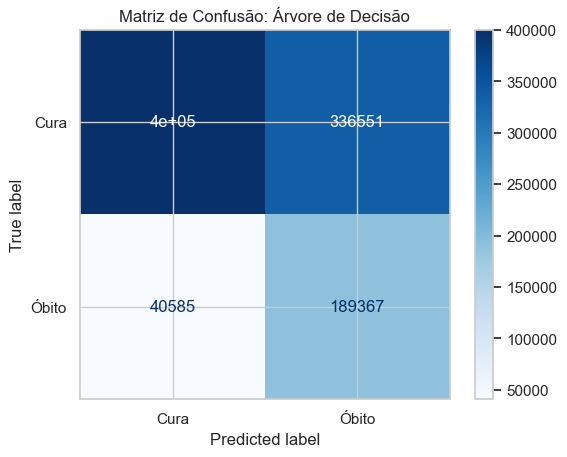

In [37]:
print("--- RELATÓRIO DE DESEMPENHO (DADOS DE TESTE) ---")
print(classification_report(y_test, y_pred))

# Visualização da Matriz de Confusão
disp = ConfusionMatrixDisplay.from_estimator(
    arvore, X_test, y_test,
    display_labels=['Cura', 'Óbito'],
    cmap='Blues'
)
plt.title("Matriz de Confusão: Árvore de Decisão")
plt.show()

**Etapa 13 - Explicação - Matriz de confusão - Árvore de Decisão**

A Matriz de confusão quantifica o acerto do modelo em cada categoria.


*   Dados : óbito X cura.
*   Conjunto de Dado : Dados de Treino

________________________________________________________________
**Explicações Preliminares**

**Verdadeiros Positivos (189.367)**: 
Indica que o modelo identificou corretamente quase 190 mil óbitos.
__________________________________________________________________
**Falsos Negativos (40.585)**: 
Indica os casos em que o modelo previu "Cura", porém o desfecho foi "Óbito".

Número significativamente menor que os acertos, indica que o Recall (Sensibilidade) é alto.
_________________________________________________________________
**Verdadeiros Negativos (400.000 ou 4e+05)**: 
Indica que o modelo identificou corretamente 400 mil curas.
__________________________________________________________________
**Falsos Positivos (336.551)**: 
Indica os dados onde o modelo previu óbito porém o desfecho foi a cura. Possivel resultado conservador.
___________________________________________________________________


**Etapa 14 - Árvore de Decisão - Relatório de Desempenho Preliminar - Árvore de Decisão**

Na etapa abaixo é implementado uma visualização da árvore de decisão, ela permite a interpretação estratificada dos dados a partir de um fator que influencie o resultado/desfecho de cura X óbito.

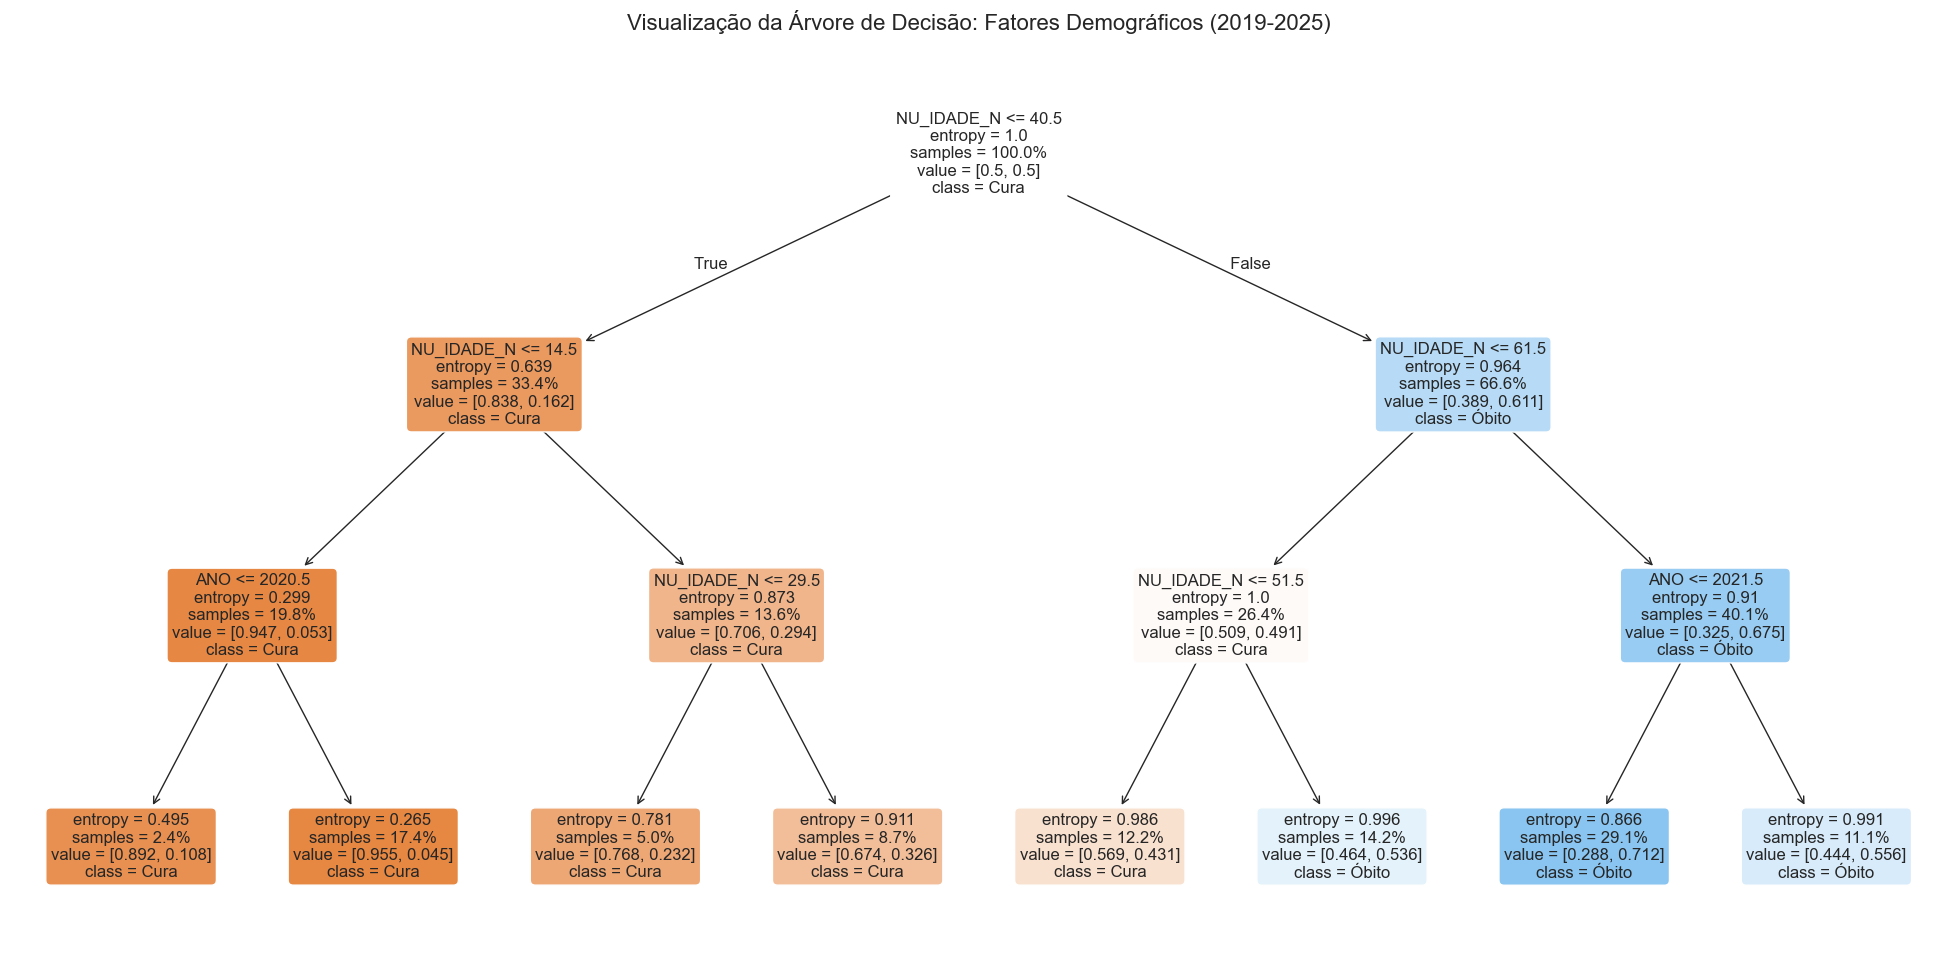

In [27]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Definindo o tamanho da imagem para ficar legível
plt.figure(figsize=(25, 12))

# Gerando o gráfico da árvore
plot_tree(
    arvore, 
    feature_names=X.columns.tolist(), 
    class_names=['Cura', 'Óbito'], 
    filled=True,      # Colore os nós conforme a classe predominante
    rounded=True,     # Bordas arredondadas
    proportion=True,  # Mostra porcentagens em vez de valores absolutos
    fontsize=12
)

plt.title("Visualização da Árvore de Decisão: Fatores Demográficos (2019-2025)", fontsize=16)
plt.show()

**Etapa 15 - Explicação - Árvore de Decisão**

Árvore de decisão apresenta um fluxograma de risco.

* **Nó-Raiz(Topo)** :  A variável no topo (NU_IDADE_N <= 40.5) é a que mais reduz a incerteza (entropia). Indica que a idade é o filtro biológico mais forte para prever o desfecho da SRAG.
*  *A idade de 40 anos e meio é a fronteira/fator crítico identificada pelo algoritmo.*

______________________________________________________________________
**Divisão**

**Caixas Laranjas (class = Cura)**: Representam grupos onde a maioria dos pacientes sobreviveu. Quanto mais escuro o laranja, maior a certeza de cura (maior a probabilidade).

**Caixas Azuis (class = Óbito)**: Representam grupos de risco onde a mortalidade é mais alta. Quanto mais escuro o azul, maior o risco.

**Value = [Cura, Óbito]**: Os números dentro dos colchetes mostram a proporção. Ex: [0.288, 0.712] significa 28.8% de cura e 71.2% de óbito.

**Esquerda (True)**: Pessoas com menos de 40.5 anos tendem fortemente à Cura (caminho laranja).

**Direita (False)**: Pessoas com mais de 40.5 anos entram na zona de risco (caminho azul).

_______________________________________________________________________
**Explicações/Interpretações**

**O Caminho da Sobrevivência (Lado Esquerdo)**

Para quem tem menos de 40 anos, o modelo indica que o risco de mortalidade é muito baixo.
Ainda que se divida entre crianças (<= 14.5) e jovens adultos (14.5 a 40.5), todas as caixas terminais (folhas) são laranjas.

**Destaque:**

Para crianças abaixo de 14 anos e meio (extrema esquerda), a chance de cura chega a 95.5% (Verificar o nó value = [0.955, 0.045]).

Tendencia de cura até jovens adultos, embora com proporções diferentes se comparados com a faixa de crianças, que tem o maior percentual.

**O Caminho do Risco (Lado Direito)**

Entre 40.5 e 61.5 anos: Existe um risco misto,porém a tendência ainda oscila (Verificar o nó azul claro vs laranja claro no meio).

Acima de 61.5 anos: O nó fica azul escuro (class = Óbito). Indica que a maioria dos casos resulta em morte.

**Destaque:**

Até 2021 (ANO <= 2021.5 ) (Pico da Pandemia): A caixa é azul mais forte. A proporção de óbito é de 71.2% (value = [0.288, 0.712]). Indica o período pré-vacinação ou as variantes mais letais.

Após 2021 (2022-2025): A caixa fica azul mais clara. A mortalidade cai para 55.6% (value = [0.444, 0.556]). Ainda existe uma mortalidade alta (possivelmente, idosos hospitalizados com SRAG), porém houve uma redução significativa na letalidade.



**Etapa 16 - Regressão Logística - Relatório de Desempenho Preliminar**
Parametros : class_weight='balanced', max_iter=1000, random_state=42

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# 1. Inicializar o modelo
# Usamos 'balanced' para compensar o desbalanceamento entre curas e óbitos
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Treinar (ajustar) o modelo aos dados de treino
log_reg.fit(X_train, y_train)

# 3. Gerar as predições para o conjunto de teste
y_pred_log = log_reg.predict(X_test)

# 4. Exibir resultados de performance
print("--- RELATÓRIO DE DESEMPENHO: REGRESSÃO LOGÍSTICA ---")
print(classification_report(y_test, y_pred_log))

# 5. Extrair e exibir os coeficientes (A "alma" da Regressão)
coef_df = pd.DataFrame({
    'Variável': X_train.columns,
    'Coeficiente': log_reg.coef_[0]
}).sort_values(by='Coeficiente', ascending=False)

print("\n--- IMPACTO POR VARIÁVEL (COEFICIENTES) ---")
print(coef_df)

C:\Users\assis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- RELATÓRIO DE DESEMPENHO: REGRESSÃO LOGÍSTICA ---
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    736952
           1       0.38      0.75      0.51    229952

    accuracy                           0.65    966904
   macro avg       0.63      0.68      0.62    966904
weighted avg       0.77      0.65      0.67    966904


--- IMPACTO POR VARIÁVEL (COEFICIENTES) ---
                          Variável  Coeficiente
8               CS_RACA_DESC_Preta     0.262122
3                        CS_SEXO_M     0.205621
5            CS_RACA_DESC_Indigena     0.200982
7               CS_RACA_DESC_Parda     0.142042
9      CS_ESCOL_DESC_Fundamental_2     0.072982
0                       NU_IDADE_N     0.041536
10             CS_ESCOL_DESC_Medio     0.012753
2                        CS_SEXO_I     0.010909
1                              ANO    -0.001098
4              CS_RACA_DESC_Branca    -0.080703
12  CS_ESCOL_DESC_Sem_Escolaridade    -0.082969

**Etapa 17 - Regressão Logística - Explicações Preliminares**


Explicações Preliminares 0 : Cura 1 : Óbito

**Precision : Precisão**

Responde à pergunta: "De todos os dados que o modelo classificou como X, quantos eram realmente X?"

Classe 0 (Cura) - 0.89: Significa que quando o modelo prevê cura, ele acerta em 89% das vezes.


Classe 1 (Óbito) - 0.38: Significa que de todos os alertas de óbito, apenas 38% se confirmam.  O restante (66%) são pessoas que o modelo achou que morreriam, mas sobreviveram (Falsos Positivos).

**Recall**

Responde a pergunta : "De todos os casos que realmente eram X na vida real, quantos o modelo conseguiu encontrar?"

Classe 0 (Cura) - 0.62: O modelo identifica 62% de todas as curas que realmente aconteceram.

*Classe 1 (Óbito) *- 0.75: O modelo consegue encontrar 75% de todos os óbitos reais.

**F1-Score**
É o equilíbrio (média harmônica) entre a Precisão e o Recall. É pertinente para identificar se o modelo está equilibrado.

Classe 0 : 0.73: Indica um desempenho sólido e equilibrado para identificar curas.
Classe 1 : 0.51: Reflete o desequilíbrio entre a alta detecção (Recall) e o alto número de alarmes falsos (Precision).


Support É a quantidade real de casos de cada classe que existiam no seu conjunto de teste.

Classe 0: 736.952: O volume total de casos de cura analisados no teste.

Classe 1: 229.952: O volume total de casos de óbito analisados no teste.


**Detalhamento sobre os Coeficientes/Impacto das variáveis**

Os coeficientes indicam o "peso" e a direção da influência de cada variável na probabilidade de óbito. Valores positivos aumentam o risco, enquanto valores negativos diminuem o risco (fatores de proteção).


**Fatores que Aumentam o Risco de Óbito (+)**
- Vulnerabilidade Racial: Pertencer à raça Preta (0.262) ou Indígena (0.200) apresenta o maior impacto positivo no risco de óbito neste modelo.

- Gênero: O sexo Masculino (0.205) possui um risco significativamente maior do que as mulheres.

- Idade: A variável NU_IDADE_N (0.041) tem um coeficiente positivo. Embora pareça baixo, este valor é aplicado de forma cumulativa, tornando-se um fator central no risco.

**Fatores de Proteção ou Menor Risco (-)**
- Escolaridade Superior: O coeficiente de -0.209 para ensino superior é um forte indicador de que o nível educacional reduz a chance de óbito.

-Localização Urbana: Morar em Zonas Urbanas (-0.172) ou Periurbanas (-0.175) está associado a uma menor probabilidade de óbito em comparação com outras categorias.
-Raça Branca: Apresenta um coeficiente negativo (-0.080), indicando um risco menor em relação à média geral da base.


**Consideração:**
Há distorções e valores não informados na base que poderiam impactar nos resultados ou no detalhamento no que se refere a fatores de proteção, a exemplo das variáveis abaixo sobre Raça e Escolaridade:
CS_ESCOL_DESC_Nao_Informado    -0.221237
CS_RACA_DESC_Nao_Informado    -0.138824


**Etapa de Otimização**
**- Matriz de Confusao - Regressao Logistica**

--- MATRIZ DE CONFUSÃO: REGRESSÃO LOGÍSTICA ---
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    736952
           1       0.38      0.75      0.51    229952

    accuracy                           0.65    966904
   macro avg       0.63      0.68      0.62    966904
weighted avg       0.77      0.65      0.67    966904



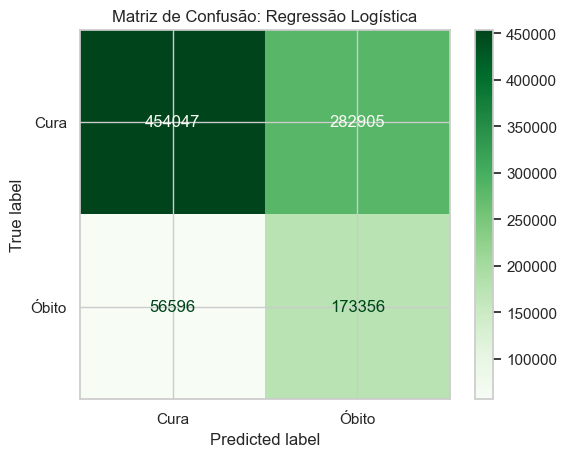

In [33]:
# Visualização da Matriz de Confusão para a Regressão Logística
print("--- MATRIZ DE CONFUSÃO: REGRESSÃO LOGÍSTICA ---")
print(classification_report(y_test, y_pred_log))
disp_log = ConfusionMatrixDisplay.from_estimator(
    log_reg, X_test, y_test, 
    display_labels=['Cura', 'Óbito'], 
    cmap='Greens'
)
plt.title("Matriz de Confusão: Regressão Logística")
plt.show()

**Etapa 18 - Otimização -  Regressão Logística : Ajuste de Escala**

Etapa : Otimização de regressão logísica, para melhorar o trabalho com grande volume de dados; normalização de escala da variável Ano e Idade; Novo Treinamento de Modelo/Predições para escala ajustada.
- 
Ajuste de Escalonamento : Parametros para novo volume de dados - Solver : Saga;
class_weight='balanced', 
max_iter=5000, 
solver='saga', 
random_state=42

- Transformação/Normalização de Escala de Variável Idade e Variável Ano;

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# 1. Escalonar os dados (Normalização Z-score)
# Isso coloca Idade, Ano e as dummies na mesma escala para o modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Treinar o modelo otimizado
# 'saga' é um solver robusto para grandes volumes de dados
modelo_otimizado = LogisticRegression(
    class_weight='balanced', 
    max_iter=5000, 
    solver='saga', 
    random_state=42
)
modelo_otimizado.fit(X_train_scaled, y_train)

# 3. Gerar as novas predições
y_pred_otimizado = modelo_otimizado.predict(X_test_scaled)

# 4. Exibir o novo Relatório de Desempenho
print("--- RELATÓRIO DE DESEMPENHO OTIMIZADO ---")
print(classification_report(y_test, y_pred_otimizado))

# 5. Criar o novo DataFrame de Coeficientes
coef_otimizado_df = pd.DataFrame({
    'Variável': X_train.columns,
    'Coeficiente_Padronizado': modelo_otimizado.coef_[0]
}).sort_values(by='Coeficiente_Padronizado', ascending=False)

print("\n--- NOVOS COEFICIENTES (PADRONIZADOS) ---")
print(coef_otimizado_df)

--- RELATÓRIO DE DESEMPENHO OTIMIZADO ---
              precision    recall  f1-score   support

           0       0.89      0.61      0.73    736952
           1       0.38      0.76      0.51    229952

    accuracy                           0.65    966904
   macro avg       0.64      0.69      0.62    966904
weighted avg       0.77      0.65      0.68    966904


--- NOVOS COEFICIENTES (PADRONIZADOS) ---
                          Variável  Coeficiente_Padronizado
0                       NU_IDADE_N                 1.122623
7               CS_RACA_DESC_Parda                 0.108783
3                        CS_SEXO_M                 0.094071
8               CS_RACA_DESC_Preta                 0.066369
5            CS_RACA_DESC_Indigena                 0.024509
9      CS_ESCOL_DESC_Fundamental_2                 0.015127
4              CS_RACA_DESC_Branca                 0.007740
2                        CS_SEXO_I                 0.002197
12  CS_ESCOL_DESC_Sem_Escolaridade              

**Etapa 19 - Otimização Regressão Logística - Explicação de Resultados - Modelo com Escala Ajustada.**

A regressão logística com escala ajusta possibilitou uma melhoria na hierarquia de importância das variáveis/coeficientes.

**Mudança Drástica nos Coeficientes**

- Idade (NU_IDADE_N): Saltou de um coeficiente de 0.04 para 1.12. Isso reforça a informação da árvore de decisão, que a idade é, de maneira consistente, o preditor individual mais forte para o óbito.

- Ano: Agora aparece com um impacto negativo relevante (-0.31). Sugere que, mantendo todas as outras variáveis constantes, o risco de óbito tendeu a diminuir ao longo do tempo na base de dados.

- Determinantes Sociais: Variáveis como Raça Parda (0.10) e Sexo Masculino (0.09) continuam sendo fatores de risco,  o modelo detalha de maneira mais precisam o impacto destes se comparados à idade.

**Matriz de Confusão de Regressao Logística com Escala Ajustada**

**Precision**

Classe 0 (Cura) 0.89 : Permanece estável.
Classe 1 (Óbito) 0.38 : Permanece estável.


**Recall**

Classe  0 (Cura) 0.61: Houve uma pequena diminuição em relação ao 0.61 anterior.
O modelo identifica 61% de todas as curas que realmente aconteceram. 

Classe 1 (Óbito) 0.76: Houve um leve ganho em relação aos 0.75 anteriores. 

**Acurácia**

Acurácia (0.65): O modelo manteve o mesmo percentual de teste anterior.


**Etapa 20 - Otimização Regressão Logistica - Ajuste de Limiar : 0.6**
Nesta etapa buscou-se uma mudança/ajuste no limiar da regressão logística
Optou-se por tentar melhorar/afinar valores de precision e recall.
Utilizou-se o limiar de 0.6.


--- RELATÓRIO DE DESEMPENHO (LIMIAR AJUSTADO PARA 0.6) ---
              precision    recall  f1-score   support

           0       0.85      0.76      0.80    736952
           1       0.43      0.57      0.49    229952

    accuracy                           0.71    966904
   macro avg       0.64      0.67      0.65    966904
weighted avg       0.75      0.71      0.73    966904

--- NOVA MATRIZ DE CONFUSÃO ---


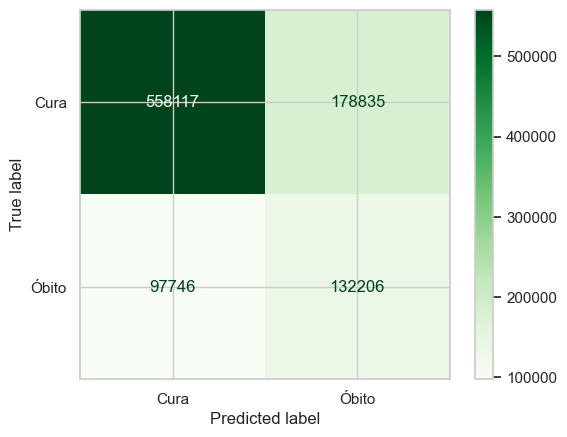

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Obter as probabilidades da classe 1 (Óbito) usando o modelo escalonado
y_probs_otimizado = modelo_otimizado.predict_proba(X_test_scaled)[:, 1]

# 2. Definir o novo limiar ( 0.6 para tentar subir a precisão)
# Pode testar valores como 0.55, 0.6 ou 0.65
limiar_escolhido = 0.6 
y_pred_limiar = (y_probs_otimizado >= limiar_escolhido).astype(int)

# 3. Exibir o Relatório com o novo ajuste
print(f"--- RELATÓRIO DE DESEMPENHO (LIMIAR AJUSTADO PARA {limiar_escolhido}) ---")
print(classification_report(y_test, y_pred_limiar))

# 4. Visualizar a nova Matriz de Confusão
print("--- NOVA MATRIZ DE CONFUSÃO ---")
cm = confusion_matrix(y_test, y_pred_limiar)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cura', 'Óbito'])
disp.plot(cmap='Greens')
plt.show()

**Etapa 21 - Explicação de Resultado - Otimização Regressão Logistica : Matriz de Confusão - Ajuste de Limiar : 0.6**

O Ajuste de limiar na regressão possibilitou um resultado/modelo mais conservador

*Matriz de Confusao de Regressao Logistica com Ajuste de Limiar : 0.6**

**Precision**

Classe 0 (Cura) 0.85 : Diminuiu levemente.
Classe 1 (Óbito) 0.43 : Melhora, indicando menos falsos-positivos.


**Recall**

Classe  0 (Cura) 0.76: Aumento. O modelo identifica 76% de todas as curas que realmente aconteceram. 

Classe 1 (Óbito) 0.57: Diminuiu: O modelo "deixa passar" mais óbitos.

**Acurácia**

Acurácia (0.71): Melhorou: O modelo acerta mais o quadro geral.

**Destaque**

Ao subir a régua para 0.6, os números absolutos mudaram drasticamente:

Falsos Positivos (Alarmes Falsos): Caíram de 282.905 para 178.835. Indica que cerca de 104 mil pessoas que seriam classificadas como "risco de óbito" agora são vistas como "provável cura".

Falsos Negativos (Risco Oculto): Subiram de 56.596 para 97.746. Custo da precisão: o modelo agora falha em prever o óbito de quase 100 mil pacientes que acabaram falecendo.

**Etapa 22 - Comparação de Modelos - Árvore de Decisão X Regressão Logística Método AUC-ROC**

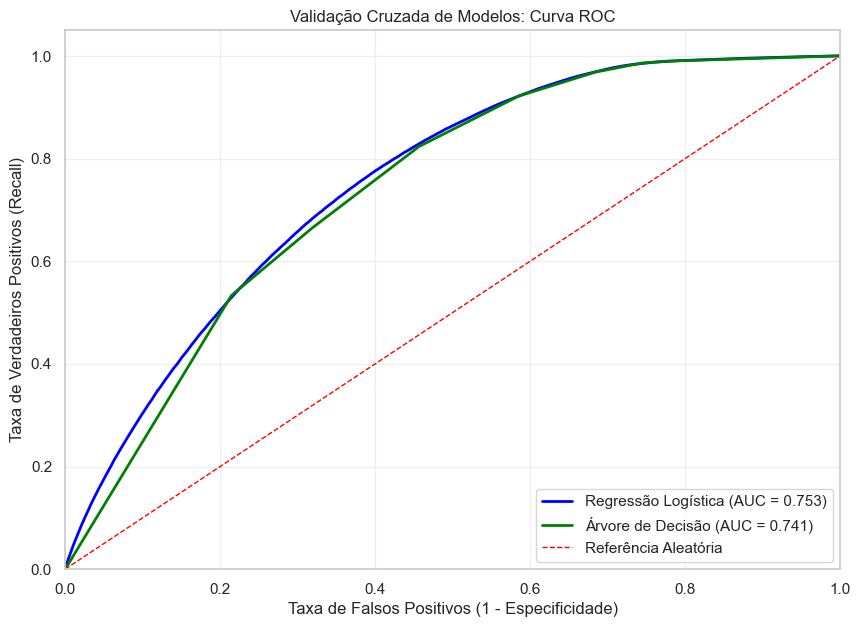

Desempenho Global (AUC):
Regressão Logística: 0.7534
Árvore de Decisão: 0.7408


In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Calcular probabilidades
# Para a Regressão Logística Otimizada (usando dados escalonados)
y_probs_log = modelo_otimizado.predict_proba(X_test_scaled)[:, 1]

# Para a Árvore de Decisão (usando dados originais do split)
y_probs_arvore = arvore.predict_proba(X_test)[:, 1]

# 2. Calcular os valores de AUC
auc_log = roc_auc_score(y_test, y_probs_log)
auc_arvore = roc_auc_score(y_test, y_probs_arvore)

# 3. Gerar os componentes da curva
fpr_log, tpr_log, _ = roc_curve(y_test, y_probs_log)
fpr_arvore, tpr_arvore, _ = roc_curve(y_test, y_probs_arvore)

# 4. Plotagem do Gráfico Comparativo
plt.figure(figsize=(10, 7))

plt.plot(fpr_log, tpr_log, color='blue', lw=2, 
         label=f'Regressão Logística (AUC = {auc_log:.3f})')

plt.plot(fpr_arvore, tpr_arvore, color='green', lw=2, 
         label=f'Árvore de Decisão (AUC = {auc_arvore:.3f})')

plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Referência Aleatória')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)')
plt.title('Validação Cruzada de Modelos: Curva ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"Desempenho Global (AUC):")
print(f"Regressão Logística: {auc_log:.4f}")
print(f"Árvore de Decisão: {auc_arvore:.4f}")

** Etapa 23 - Explicação - Curva ROC AUC **

Os modelos selecionados foram : Arvore de Decisão e Regressão Logística Otimizada

Os resultados  indicam que :
- Regressão Logística (0.7534): Este modelo foi ligeiramente superior. Ele tem 75,3% de chance de classificar corretamente um par aleatório de pacientes (um que veio a óbito e outro que se curou).

- Árvore de Decisão (0.7408): Apesar de ser um modelo  simples (apenas 3 níveis de profundidade), ela quase alcançou a performance da regressão. Destaca-se que a Idade, por si só, é um fator determinante no desfecho de SRAG analisado.

**Etapa 24 - Considerações Gerais de Análise**

1 - Desempenho de Modelos : Árvore de Decisão e Regressão Logística

Nesta pesquisa, foram aplicados dois modelos complementares de aprendizado de máquina para avaliar o impacto de determinantes demográficos no desfecho da SRAG (Cura vs. Óbito). O modelo de Árvore de Decisão apresentou uma sensibilidade (Recall) superior para a classe de óbitos (0.82), demonstrando ser uma ferramenta eficaz para a triagem inicial e identificação de grupos/fatores de risco. Por outro lado, o modelo de Regressão Logística Otimizado, após a padronização dos dados e ajuste de limiar para 0.6, atingiu uma acurácia de 0.71, oferecendo um equilíbrio mais refinado entre precisão e sensibilidade.


2 - Determinantes Demográficos

A análise revelou que a idade é o principal determinante demográfico de mortalidade. Na Árvore de Decisão, o primeiro corte crítico ocorreu aos 61.5 anos, enquanto na Regressão Logística, a variável NU_IDADE_N obteve o maior peso relativo (coeficiente de 1.12).

Observou-se também um efeito temporal significativo: a variável ANO apresentou um coeficiente negativo (-0.31). Indicando que, controlando-se as demais variáveis, o risco relativo de óbito diminuiu ao longo do período analisado, o que pode ser atribuído ao avanço da vacinação e ao aprimoramento dos protocolos clínicos hospitalares.

3 - Disparidades Sociais e Vulnerabilidades

A Regressão Logística permitiu isolar o impacto de determinantes demográficos que não eram tão evidentes na árvore. Mesmo após o ajuste por idade e ano; as variáveis a seguir merecem atenção e destaque enquanto fatores de risco :  (1) variáveis de raça apresentaram coeficientes positivos, vinculadas a Raça Parda (0.10), Raça Preta (0.06); (2) variável Sexo Masculino com significativo impacto (0.09), (3) variável Raça Descendencia Indígena (0.02). Pontua-se também a pertinencia da variável de escolaridade fundamental 2 (0.01). Estes determinantes demográficos podem indicar grupos que merecem um maior atenção ou que se encontram em situações de maior vulnerabilidade quanto ao acesso e garantia à saúde.

Em contrapartida, a Escolaridade Superior (-0.04) e a residência em Zona Urbana (-0.06) atuaram como fatores de proteção, sugerindo que o acesso à informação e à infraestrutura de saúde são determinantes críticos para a sobrevivência.

4 - Limiar e Tomada de Decisão

A Matriz de Confusão do modelo ajustado para o limiar de 0.6 revelou uma redução significativa nos falsos positivos (de 282.905 para 178.835) em comparação ao modelo padrão com limiar 0.5. Esta otimização é fundamental em cenários de saúde pública onde a precisão na alocação de recursos (como leitos de UTI) é prioritária. No entanto, o aumento dos falsos negativos (97.746) reforça a necessidade de manter a Árvore de Decisão como uma ferramenta de suporte para evitar que casos graves sejam subestimados em uma triagem inicial

5 - Escolha de Modelos

A Arvore de decisão possibilita visualizar a estratificação do risco de SRAG, é perceptível o salto visual quanto a mortalidade quando o paciente-alvo tem mais de 60 anos. Por outro lado, o paciente jovem tem uma tendência a cura de maneira visualmente identificável.

A Regressão Logística possibilita apontar o impacto de fatores sociais vinculados ao desfecho de óbito ou cura. Em especial a regressão logística otimizada com os coeficientes padronizados corrobora o impacto da idade enquanto um determinante central, visualizado na árvore de decisão, ademais indica os fatores demográficos mais pertinentes vinculados a fatores de risco de óbito de SRAG.

6 - Desempenho Consistente de Modelos

A análise da Área Sob a Curva (AUC-ROC) revelou um desempenho consistente entre os dois modelos. Indicando que a inclusão dos pesos graduais das variáveis socioeconômicas (como raça e escolaridade) refina a capacidade de distinção do modelo.

A proximidade dos valores sugere que o desfecho da SRAG é fortemente ditado por padrões claros e lineares - em especial a idade - , permitindo que mesmo modelos de alta interpretabilidade, como a árvore de decisão de profundidade 3, alcancem um patamar de precisão aceitável para aplicações em saúde pública.
